# FIG. 3. Travel likelihood data from the ‘German Mobility Panel’ (MOP)

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import osmnx as ox
import cartopy.crs as ccrs

crs = ccrs.GOOGLE_MERCATOR
from scipy.optimize import curve_fit
from scipy.spatial import Voronoi
import shapely


labelsize = 24
pgf_with_latex = {  # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",  # change this if using xetex or lautex
    "text.usetex": True,  # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],  # blank entries should cause plots
    "font.sans-serif": [],  # to inherit fonts from the document
    "font.monospace": [],
    "axes.labelsize": labelsize,  # LaTeX default is 10pt font.
    "font.size": labelsize,
    "legend.fontsize": labelsize,  # Make the legend/label fonts
    "xtick.labelsize": labelsize,  # a little smaller
    "ytick.labelsize": labelsize,
    "figure.figsize": (12, 8),  # default fig size of 0.9 textwidth
    "pgf.preamble": "\n".join(
        [  # plots will use this preamble
            r"\usepackage[utf8]{inputenc}",
            r"\usepackage[T1]{fontenc}",
            # r"\usepackage[detect-all,locale=DE]{siunitx}",
        ]
    ),
}
mpl.rcParams.update(pgf_with_latex)


from src import GermanMobiltyPanel as gmp
from src import RoadNetwork as rn
from src import PopulationFromRaster as pfr
from src import SupportFunctions as sf


### Create RoadNetwork from bbox and, set nodal population and compute Voronoi regions

In [3]:
west, east = 6.65, 7.4
south, north = 50.25, 50.75

driving_tags = [
    "motorway",
    "motorway_link",
    "trunk",
    "trunk_link",
    "primary",
    "primary_link",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
    "unclassified",
    "residential",
]
highway_filter = f"w/highway={','.join(driving_tags)}"

region = rn.RoadNetwork(
    osmpbf="germany.osm.pbf",
    highway_filter=highway_filter,
    bbox=[north, south, west, east],
)

nodes, edges = ox.graph_to_gdfs(region.graph)
nodes = sf.voronoi_region_of_nodes(nodes)

prim = ["motorway", "trunk", "primary", "motorway_link", "trunk_link", "primary_link"]
prim_edg = edges[edges["highway"].apply(lambda x: x in prim)]
sec = ["secondary", "secondary_link"]
sec_edg = edges[edges["highway"].apply(lambda x: x in sec)]
tert = ["tertiary", "tertiary_link"]
tert_edg = edges[edges["highway"].apply(lambda x: x in tert)]


num(nodes)= 32253
num(edges)= 76950


### Fit GMP mobility data. Linear increase until maximum, followed by an exponential decrease

In [4]:
bincount = 200
attr = "travel_time"

max_bin, popt_exp, popt_lin = gmp.mobility_fit_params(
    "data/GMP/mobility/", attr, bincount=bincount
)
mobility_fit = (
    lambda x: gmp.exp_func(x, *popt_exp) if x > max_bin else gmp.lin_func(x, *popt_lin)
)

data_points = gmp.read_PT_kmPKW_files("data/GMP/mobility/", attr) * 60
data_pkw, bins = np.histogram(data_points, bins=bincount, density=True)
binscenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])


### Create Figure

/Users/jonas/miniconda3/envs/op311/lib/python3.11/site-packages/shapely/measurement.py:45: RuntimeWarning: invalid value encountered in area
  return lib.area(geometry, **kwargs)


<GeoAxes: >

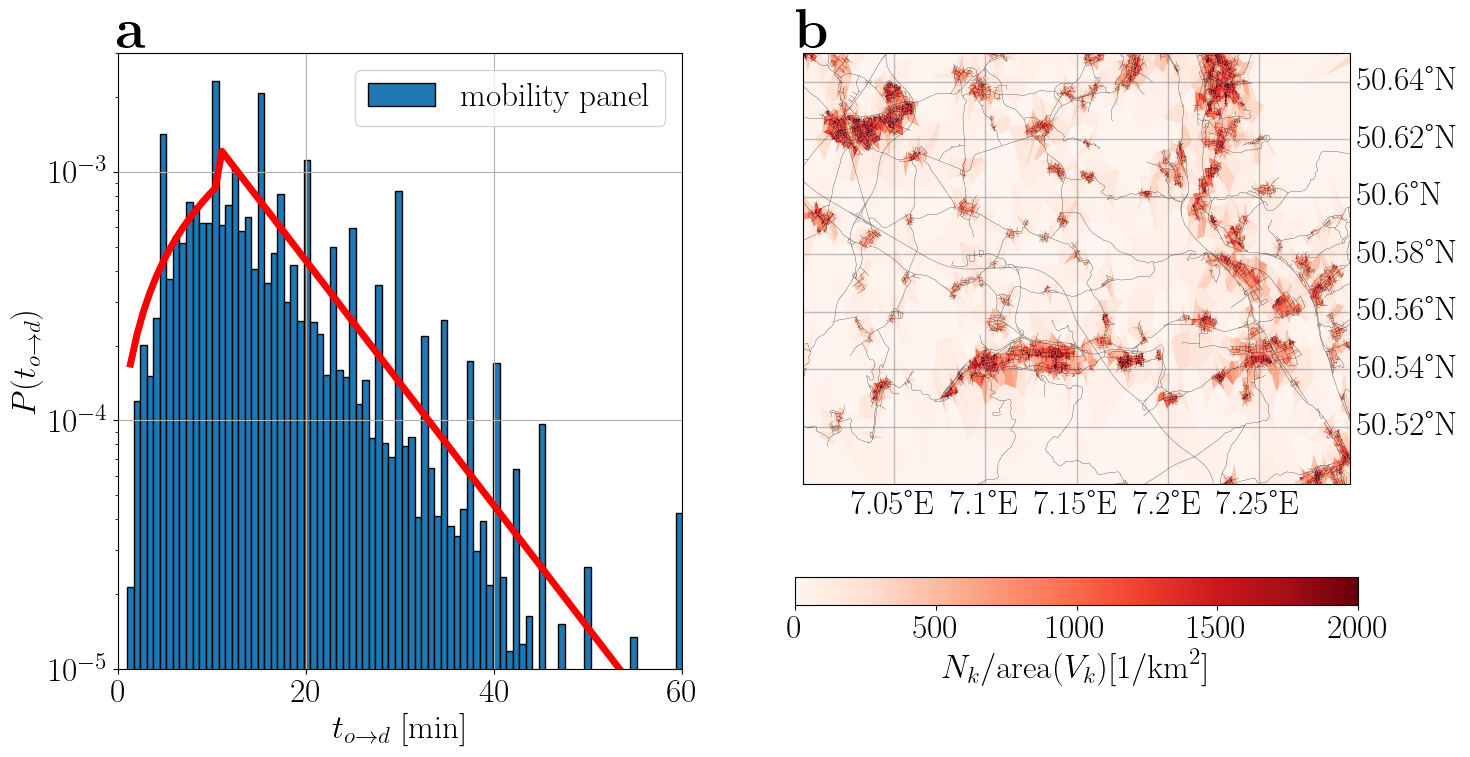

In [5]:
fig = plt.figure(figsize=(16, 8))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0, 1], projection=crs)
ax1.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels={"bottom": "x", "right": "y"},
    linewidth=1,
    color="gray",
    alpha=0.5,
    linestyle="-",
)
west, east = 7.0, 7.3
south, north = 50.5, 50.65
ax1.set_extent([west, east, south, north], crs=ccrs.PlateCarree())
ax0 = fig.add_subplot(spec[0, 0])


ax0.text(
    0.05,
    1.07,
    r"\textbf{a}",
    transform=ax0.transAxes,
    fontweight="bold",
    fontsize=40,
    va="top",
    ha="right",
)
# ax.set_title('Typical traffic volume')
ax1.text(
    0.05,
    1.1,
    r"\textbf{b}",
    transform=ax1.transAxes,
    fontweight="bold",
    fontsize=40,
    va="top",
    ha="right",
)
#######################################################################
ax0.bar(
    binscenters / 60,
    data_pkw,
    width=(bins[1] - bins[0]) / 60,
    edgecolor="black",
    label="mobility panel",
)
ax0.plot(
    binscenters / 60, [mobility_fit(x) for x in binscenters], linewidth=5, color="red"
)

ax0.legend()
ax0.set_ylabel(r"$P(t_{o \to d})$")
ax0.set_xlabel(r"$t_{o \to d}$ [min]")
ax0.grid()
ax0.set_xlim([0, 60])
ax0.set_ylim([1e-5, 3e-3])
ax0.set_yscale("log")


########################################################################
cmap = "Reds"

vor_nodes = nodes.set_geometry("Voronoi").set_crs(edges.crs).to_crs(crs.proj4_init)
vor_nodes["pop_density"] = vor_nodes["population"] / (vor_nodes.area) * 1e6
vmin = 0
vmax = 2000

vor_nodes.plot(
    ax=ax1, column="pop_density", zorder=-1, cmap=cmap, vmin=vmin, vmax=vmax, alpha=1
)
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap="Reds"),
    ax=ax1,
    location="bottom",
)
cbar.ax.set_xlabel(r"$N_{k}/\mathrm{area}(V_k) [1/\mathrm{km}^2$]")

edges.to_crs(crs.proj4_init).plot(ax=ax1, color="black", linewidth=0.1, zorder=2)


In [10]:
fig.savefig("results/figs/FIG3-Travel-function.png", bbox_inches="tight")
